In [1]:
import numpy as np
import pandas as pd
from pycytominer.cyto_utils import infer_cp_features
import sys
import matplotlib.pyplot as plt
sys.path.insert(0, "../../scripts")
from utils import load_data
from tensorflow import keras
from scipy.stats import pearsonr, ttest_ind, ttest_1samp

import seaborn
from sklearn.decomposition import PCA
import random

In [2]:
np.random.seed(82)
NUM_RANDOM_SAMPLES = 10

In [3]:
data_dict = load_data(["complete"])
meta_features = infer_cp_features(data_dict["complete"], metadata=True)
cp_features = infer_cp_features(data_dict["complete"])

complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [4]:
latent_dim = 90
latent_space_columns = np.arange(0,latent_dim)
latent_space_columns = [(latent_space_column) for latent_space_column in latent_space_columns]

In [5]:
encoder = keras.models.load_model("../2.train/level4Encoder_mmd")
latent_df = pd.DataFrame(encoder.predict(complete_features_df)[2])

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1059: UserWarning: vae_utils is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [6]:
# latent_df = pd.read_csv("level4Latent.csv").drop("Unnamed: 0", axis = 1)
pca = PCA(n_components=latent_dim)
pca_latent_df = pd.DataFrame(pca.fit_transform(complete_features_df), columns = latent_space_columns)

In [7]:
moa_df = pd.read_csv("repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_sample').reindex(index=complete_meta_df['Metadata_broad_sample']).reset_index().drop('Metadata_broad_sample',axis = 1)
meta_moa_latent_df = pd.concat([complete_meta_df,moa_df,latent_df], axis=1)
meta_moa_pca_latent_df = pd.concat([complete_meta_df,moa_df,pca_latent_df], axis=1)
meta_moa_complete_df = pd.concat([complete_meta_df,moa_df,complete_features_df], axis=1)

# fill negative control DMSO profiles, change the NaN MOA label to be DMSO
meta_moa_latent_df.loc[meta_moa_latent_df['Metadata_broad_sample'] == 'DMSO', 'moa'] = 'DMSO'
meta_moa_pca_latent_df.loc[meta_moa_pca_latent_df['Metadata_broad_sample'] == 'DMSO', 'moa'] = 'DMSO'
meta_moa_complete_df.loc[meta_moa_complete_df['Metadata_broad_sample'] == 'DMSO', 'moa'] = 'DMSO'

#drop profiles with NaN MOAs
meta_moa_latent_df = meta_moa_latent_df.dropna(subset=['moa']).reset_index(drop = True)
meta_moa_pca_latent_df = meta_moa_pca_latent_df.dropna(subset=['moa']).reset_index(drop = True)
meta_moa_complete_df = meta_moa_complete_df.dropna(subset=['moa']).reset_index(drop = True)

# add columns to the dataframe that are randomnly shuffled permutations of the MOA column
for i in range(NUM_RANDOM_SAMPLES):
    random_moa_labels = pd.DataFrame([meta_moa_latent_df.moa.sample(frac=1)]).transpose().reset_index().drop('index', axis = 1)
    random_moa_labels = random_moa_labels.rename(columns={'moa': 'random_moa_labels' + str(i)})

    meta_moa_latent_df = pd.concat([random_moa_labels, meta_moa_latent_df], axis=1)
    meta_moa_pca_latent_df = pd.concat([random_moa_labels, meta_moa_pca_latent_df], axis=1)

    meta_moa_complete_df = pd.concat([random_moa_labels, meta_moa_complete_df], axis=1)

meta_moa_complete_df.head()

,random_moa_labels9,random_moa_labels8,random_moa_labels7,random_moa_labels6,random_moa_labels5,random_moa_labels4,random_moa_labels3,random_moa_labels2,random_moa_labels1,random_moa_labels0,...,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_20_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_SumVariance_DNA_20_0,Nuclei_Texture_SumVariance_RNA_20_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0
0,NFkB pathway inhibitor|proteasome inhibitor,acetylcholine receptor antagonist,SRC activator,sodium channel blocker,potassium channel blocker,JAK inhibitor,angiotensin converting enzyme inhibitor,electrolyte reabsorption inhibitor|thromboxane...,DMSO,acetylcholine release enhancer,...,0.60865,0.38869,0.65364,0.65716,0.24912,0.33129,0.28864,0.27106,0.35254,0.32675
1,DNA inhibitor,angiogenesis inhibitor,antioxidant,serotonin receptor agonist,HMGCR inhibitor,lipid peroxidase inhibitor,cyclooxygenase inhibitor|lipoxygenase inhibitor,proteasome inhibitor,antiamyloidogenic agent,topoisomerase inhibitor,...,0.60682,0.39779,0.64013,0.63120,0.24380,0.30471,0.28554,0.27852,0.35157,0.31637
2,tyrosine kinase inhibitor,growth hormone secretagogue receptor agonist,NFkB pathway inhibitor|proteasome inhibitor,tubulin polymerization inhibitor,glutamate receptor modulator,EGFR inhibitor|protein tyrosine kinase inhibitor,androgen receptor antagonist,HDAC inhibitor,FLT3 inhibitor|growth factor receptor inhibito...,microtubule stabilizing agent|tubulin polymeri...,...,0.60665,0.39705,0.66616,0.62889,0.25125,0.33549,0.29656,0.25706,0.33868,0.31901
3,CDK inhibitor|glycogen synthase kinase inhibitor,microtubule inhibitor|tubulin polymerization i...,proteasome inhibitor,diacylglycerol O acyltransferase inhibitor,immunostimulant,opioid receptor agonist,insulin sensitizer|PPAR receptor agonist,gastrin inhibitor|urease inhibitor,cyclooxygenase inhibitor|lipoxygenase inhibitor,ATPase inhibitor|gastrin inhibitor,...,0.60225,0.40182,0.64151,0.64488,0.24517,0.33941,0.29732,0.25350,0.34293,0.33217
4,sodium/hydrogen exchanger inhibitor,non-nucleoside reverse transcriptase inhibitor,proteasome inhibitor,glucocorticoid receptor agonist|immunosuppressant,cyclooxygenase inhibitor,dopamine reuptake inhibitor,dipeptidyl peptidase inhibitor,HMGCR inhibitor,voltage-gated sodium channel modulator,DNA methyltransferase inhibitor,...,0.61137,0.39456,0.64882,0.64924,0.25610,0.32517,0.30377,0.27170,0.34711,0.32894


In [8]:
moas_occurrence = pd.read_csv("moas_occurrence.tsv", sep = "\t")
moas_occurrence.index = moas_occurrence['moa']
moas_occurrence = moas_occurrence.drop('moa', axis = 1)

#We only want moa combinations with enough data, so we pick A|B such that there are at least 5 A|B, 5 A, and 5 B.
valid_pipes = moas_occurrence[((moas_occurrence != 0).all(axis = 1)) & (moas_occurrence['full moa occurrence'] > 0) & (moas_occurrence['moa1 occurrence'] > 0)& (moas_occurrence['moa2 occurrence'] > 0)].index
valid_pipes = valid_pipes[valid_pipes.str.count("\|") == 1]

In [9]:
def subset_by_moa(pipe, df_name, column):
    moas = pipe.split("|")
    subset_df = pd.concat([df_name[df_name[column] == moas[0]],df_name[df_name[column] == moas[1]]])
    return subset_df

def LSA(A, B, D):
    return A-D+B

In [10]:
#calculate means for each A and B in each A|B.
subset_means = []
subset_random_means = []
subset_pca_means = []
subset_pca_random_means = []
subset_complete_means = []
subset_complete_random_means = []

for pipe in valid_pipes:
    subset = subset_by_moa(pipe, meta_moa_latent_df, 'moa')
    subset_mean = subset.groupby(['moa'])[latent_space_columns].mean()
    subset_pca = subset_by_moa(pipe, meta_moa_pca_latent_df, 'moa')
    subset_pca_mean = subset_pca.groupby(['moa'])[latent_space_columns].mean()
    subset_complete = subset_by_moa(pipe, meta_moa_complete_df, 'moa')
    subset_complete_mean = subset_complete.groupby(['moa'])[complete_features_df.columns].mean()
    
    
    subsets_random_mean = []
    subsets_pca_random_mean = []
    subsets_complete_random_mean = []
    for i in range(NUM_RANDOM_SAMPLES):
        label = 'random_moa_labels' + str(i)
        subset_random = subset_by_moa(pipe, meta_moa_latent_df, label)
        subset_random_mean = subset_random.groupby([label])[latent_space_columns].mean()
        subsets_random_mean.append(subset_random_mean)
        
        subset_pca_random = subset_by_moa(pipe, meta_moa_pca_latent_df, label)
        subset_pca_random_mean = subset_pca_random.groupby([label])[latent_space_columns].mean()
        subsets_pca_random_mean.append(subset_pca_random_mean)
        
        subset_complete_random = subset_by_moa(pipe, meta_moa_complete_df, label)
        subset_complete_random_mean = subset_complete_random.groupby([label])[complete_features_df.columns].mean()
        subsets_complete_random_mean.append(subset_complete_random_mean)
    
    subset_means.append(subset_mean)
    subset_pca_means.append(subset_pca_mean)
    subset_complete_means.append(subset_complete_mean)
    
    subset_random_means.append(subsets_random_mean)
    subset_pca_random_means.append(subsets_pca_random_mean)
    subset_complete_random_means.append(subsets_complete_random_mean)



In [11]:
#calculate means for DMSO
DMSO = meta_moa_latent_df[meta_moa_latent_df.moa == 'DMSO']
DMSO_pca = meta_moa_pca_latent_df[meta_moa_pca_latent_df.moa == 'DMSO']
DMSO_complete = meta_moa_complete_df[meta_moa_complete_df.moa == 'DMSO']

DMSO_means = np.mean(DMSO[latent_space_columns])
DMSO_means_pca = np.mean(DMSO_pca[latent_space_columns])
DMSO_means_complete = np.mean(DMSO_complete[complete_features_df.columns])


DMSO_means_random = []
DMSO_means_pca_random = []
DMSO_means_complete_random = []

for i in range(NUM_RANDOM_SAMPLES):
    label = 'random_moa_labels' + str(i)
    DMSO_random = meta_moa_latent_df[meta_moa_latent_df[label] == 'DMSO']
    DMSO_means_random.append(np.mean(DMSO_random[latent_space_columns]))

    DMSO_pca_random = meta_moa_pca_latent_df[meta_moa_pca_latent_df[label] == 'DMSO']
    DMSO_means_pca_random.append(np.mean(DMSO_pca_random[latent_space_columns]))
    
    DMSO_complete_random = meta_moa_complete_df[meta_moa_complete_df[label] == 'DMSO']
    DMSO_means_complete_random.append(np.mean(DMSO_complete_random[complete_features_df.columns]))

In [12]:
#perform latent space arithmetic
representations_after_LSA = []
representations_after_LSA_random = []
representations_after_LSA_pca = []
representations_after_LSA_pca_random = []
representations_after_LSA_complete = []
representations_after_LSA_complete_random = []


for i in range(len(subset_means)):
    representation_after_LSA = LSA(subset_means[i].loc[valid_pipes[i].split("|")[0]],subset_means[i].loc[valid_pipes[i].split("|")[1]],DMSO_means)
    representation_after_LSA = pd.DataFrame(representation_after_LSA).transpose()
    representations_after_LSA.append(representation_after_LSA)
    
    representation_after_LSA_pca = LSA(subset_pca_means[i].loc[valid_pipes[i].split("|")[0]],subset_pca_means[i].loc[valid_pipes[i].split("|")[1]],DMSO_means_pca)
    representation_after_LSA_pca = pd.DataFrame(representation_after_LSA_pca).transpose()
    representations_after_LSA_pca.append(representation_after_LSA_pca)
    
    representation_after_LSA_complete = LSA(subset_complete_means[i].loc[valid_pipes[i].split("|")[0]],subset_complete_means[i].loc[valid_pipes[i].split("|")[1]],DMSO_means_complete)
    representation_after_LSA_complete = pd.DataFrame(representation_after_LSA_complete).transpose()
    representations_after_LSA_complete.append(representation_after_LSA_complete)
    
    
    LSA_random_1pipe = []
    PCA_random_1pipe = []
    complete_random_1pipe = []
    for j in range(NUM_RANDOM_SAMPLES):
        representation_after_LSA_random = LSA(subset_random_means[i][j].loc[valid_pipes[i].split("|")[0]],subset_random_means[i][j].loc[valid_pipes[i].split("|")[1]],DMSO_means_random[j])
        representation_after_LSA_random = pd.DataFrame(representation_after_LSA_random).transpose()
        LSA_random_1pipe.append(representation_after_LSA_random)    

        representation_after_LSA_pca_random = LSA(subset_pca_random_means[i][j].loc[valid_pipes[i].split("|")[0]],subset_pca_random_means[i][j].loc[valid_pipes[i].split("|")[1]],DMSO_means_pca_random[j])
        representation_after_LSA_pca_random = pd.DataFrame(representation_after_LSA_pca_random).transpose()
        PCA_random_1pipe.append(representation_after_LSA_pca_random)
        
        representation_after_LSA_complete_random = LSA(subset_complete_random_means[i][j].loc[valid_pipes[i].split("|")[0]],subset_complete_random_means[i][j].loc[valid_pipes[i].split("|")[1]],DMSO_means_complete_random[j])
        representation_after_LSA_complete_random = pd.DataFrame(representation_after_LSA_complete_random).transpose()
        complete_random_1pipe.append(representation_after_LSA_complete_random)
        
    representations_after_LSA_random.append(LSA_random_1pipe)
    representations_after_LSA_pca_random.append(PCA_random_1pipe)
    representations_after_LSA_complete_random.append(complete_random_1pipe)


In [13]:
decoder = keras.models.load_model("../2.train/level4Decoder_mmd")


In [14]:
#decode each latent space representation

predictions = []
predictions_random = []
predictions_pca = []
predictions_pca_random = []
predictions_complete = []
predictions_complete_random = []

for i in range(len(representations_after_LSA)):
    predictions.append(decoder.predict(representations_after_LSA[i]))
    predictions_pca.append(pca.inverse_transform(representations_after_LSA_pca[i]))
    predictions_complete.append(representations_after_LSA_complete[i].values.tolist())
    
    predictions_random_1pipe = []
    predictions_pca_random_1pipe = []
    predictions_complete_random_1pipe = []
    for j in range(NUM_RANDOM_SAMPLES):
        predictions_random_1pipe.append(decoder.predict(representations_after_LSA_random[i][j]))
        predictions_pca_random_1pipe.append(pca.inverse_transform(representations_after_LSA_pca_random[i][j]))
        predictions_complete_random_1pipe.append(representations_after_LSA_complete_random[i][j].values.tolist())

    predictions_random.append(predictions_random_1pipe)
    predictions_pca_random.append(predictions_pca_random_1pipe)
    predictions_complete_random.append(predictions_complete_random_1pipe)
        
predictions = np.array(predictions)
predictions_random = np.array(predictions_random)
predictions_pca = np.array(predictions_pca)
predictions_pca_random = np.array(predictions_pca_random)
predictions_complete = np.array(predictions_complete)
predictions_complete_random = np.array(predictions_complete_random)

In [15]:
# meta_moa_complete_df.columns.to_list()

In [16]:
mean_of_moas = meta_moa_complete_df.groupby(['moa']).mean().loc[:,'Cells_AreaShape_Compactness':]
mean_of_moas = mean_of_moas[mean_of_moas.index.str.contains('\|')]

In [17]:
# calculates all L2 distances for both per MOA combo and general distribution comparison for all MOA combos
L2 = []
L2_random = []
L2_pca = []
L2_pca_random = []
L2_complete = []
L2_complete_random = []


per_moa_pvalues_vae = []
per_moa_tstat_vae = []
per_moa_pvalues_pca = []
per_moa_tstat_pca = []
per_moa_pvalues_complete = []
per_moa_tstat_complete = []

for i in range(len(valid_pipes)):
    desired_moa = np.array(mean_of_moas[mean_of_moas.index == valid_pipes[i]])
    
    L2.append(np.linalg.norm(predictions[i][0]-desired_moa[0]))
    L2_pca.append(np.linalg.norm(predictions_pca[i][0]-desired_moa[0]))
    L2_complete.append(np.linalg.norm(predictions_complete[i][0]-desired_moa[0]))

    
    L2_random_per_moa = []
    L2_pca_random_per_moa = []
    L2_complete_random_per_moa = []
    for j in range(NUM_RANDOM_SAMPLES):
        L2_random_per_moa.append(np.linalg.norm(predictions_random[i][j][0]-desired_moa[0]))
        L2_pca_random_per_moa.append(np.linalg.norm(predictions_pca_random[i][j][0]-desired_moa[0]))
        L2_complete_random_per_moa.append(np.linalg.norm(predictions_complete_random[i][j][0]-desired_moa[0]))
    
    L2_random += L2_random_per_moa
    L2_pca_random += L2_pca_random_per_moa
    L2_complete_random += L2_complete_random_per_moa
    
    tstat_vae, pval_vae = ttest_1samp(L2_random_per_moa, np.linalg.norm(predictions[i][0]-desired_moa[0]))
    tstat_pca, pval_pca = ttest_1samp(L2_pca_random_per_moa, np.linalg.norm(predictions_pca[i][0]-desired_moa[0]))
    tstat_complete, pval_complete = ttest_1samp(L2_complete_random_per_moa, np.linalg.norm(predictions_complete[i][0]-desired_moa[0]))
        
    per_moa_pvalues_vae.append(pval_vae)
    per_moa_tstat_vae.append(tstat_vae)
    per_moa_pvalues_pca.append(pval_pca)
    per_moa_tstat_pca.append(tstat_pca)
    per_moa_pvalues_complete.append(pval_complete)
    per_moa_tstat_complete.append(tstat_complete)


In [18]:
per_moa_performance_df = pd.DataFrame({"MOA":valid_pipes,"vae pvalue":per_moa_pvalues_vae,"vae tstat":per_moa_tstat_vae,"pca pvalue":per_moa_pvalues_pca,"pca tstat":per_moa_tstat_pca})
per_moa_performance_df.to_csv('ttest_per_moa.tsv', sep = '\t')


In [19]:
per_moa_performance_df = per_moa_performance_df.sort_values('vae tstat')
per_moa_performance_df.to_csv('level4_moa_performance.csv')

In [20]:
well_predicted = per_moa_performance_df[per_moa_performance_df['vae tstat'] < 0]
well_predicted.to_csv('well_predicted_level4.csv')
well_predicted

,MOA,vae pvalue,vae tstat,pca pvalue,pca tstat
31,CDK inhibitor|glycogen synthase kinase inhibitor,1.406777e-21,-535.466374,4.958038e-11,-35.930947
82,benzodiazepine receptor agonist|HDAC inhibitor,1.152879e-20,-423.859594,9.963554e-11,-33.232234
78,DNA synthesis inhibitor|microtubule inhibitor,5.579694e-18,-213.244953,8.012233e-09,-20.285507
47,antiviral|RNA synthesis inhibitor,5.429334e-17,-165.599928,3.967592e-07,-12.967399
23,AKT inhibitor|mTOR inhibitor,5.761365e-17,-164.511009,2.834239e-09,-22.814941
69,acetylcholinesterase inhibitor|microtubule inh...,7.047120e-17,-160.868593,2.749131e-10,-29.660382
46,apoptosis stimulant|ribonucleotide reductase i...,1.181588e-16,-151.888031,7.464875e-05,-6.851012
32,cytochrome P450 inhibitor|protein synthesis in...,1.471811e-15,-114.750899,8.167891e-10,-26.246874
45,DNA synthesis inhibitor|thymidylate synthase i...,4.636841e-08,-16.611213,3.039945e-01,-1.090098
14,acetylcholinesterase inhibitor|cholinesterase ...,7.544473e-07,-12.028755,1.716612e-02,-2.915173


In [21]:
L2_df = pd.DataFrame(L2, columns = ['VAE Unshuffled'])
L2_random_df = pd.DataFrame(L2_random, columns = ['VAE Shuffled'])
L2_pca_df = pd.DataFrame(L2_pca, columns = ['PCA Unshuffled'])
L2_pca_random_df = pd.DataFrame(L2_pca_random, columns = ['PCA Shuffled'])
L2_complete_df = pd.DataFrame(L2_complete, columns = ['Complete Unshuffled'])
L2_complete_random_df = pd.DataFrame(L2_complete_random, columns = ['Complete Shuffled'])
L2_df = pd.concat([L2_df, L2_random_df, L2_pca_df, L2_pca_random_df, L2_complete_df, L2_complete_random_df], ignore_index = True, axis = 1)
L2_df.columns = ['VAE Unshuffled','VAE Shuffled','PCA Unshuffled','PCA Shuffled','Complete Unshuffled','Complete Shuffled']
L2_df.to_csv('L2_general.tsv', sep = '\t')


# L2_df = pd.DataFrame(L2, columns = ['VAE Unshuffled'])
# L2_random_df = pd.DataFrame(L2_random, columns = ['VAE Shuffled'])
# L2_pca_df = pd.DataFrame(L2_pca, columns = ['PCA Unshuffled'])
# L2_pca_random_df = pd.DataFrame(L2_pca_random, columns = ['PCA Shuffled'])
# L2_df = pd.concat([L2_df, L2_random_df, L2_pca_df, L2_pca_random_df], ignore_index = True, axis = 1)
# L2_df.columns = ['VAE Unshuffled','VAE Shuffled','PCA Unshuffled','PCA Shuffled']
# L2_df.to_csv('L2_general.tsv', sep = '\t')

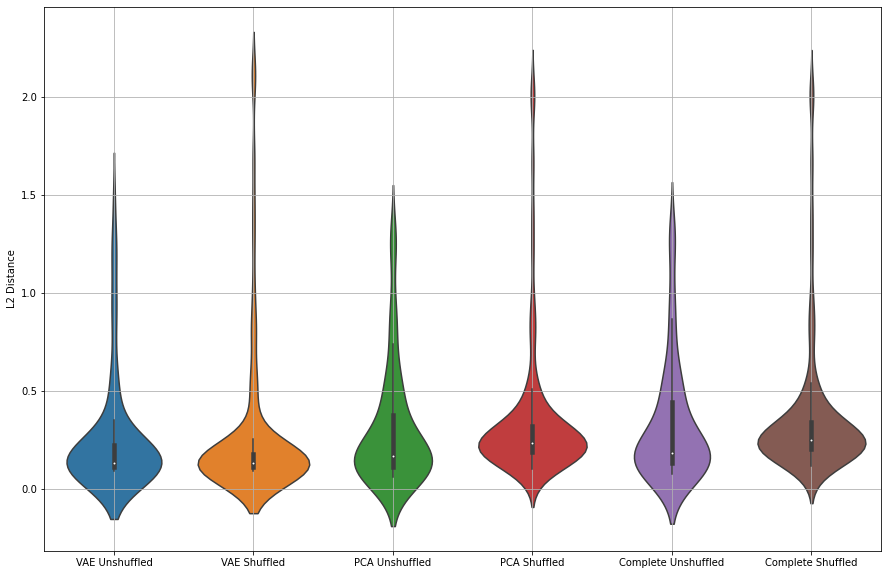

In [22]:
import matplotlib.ticker as plticker

fig, ax = plt.subplots(figsize=(15, 10))
ax = seaborn.violinplot(data = L2_df)
ax.set(ylabel = "L2 Distance")
plt.grid()

plt.show()

In [23]:
L2_df.describe()

,VAE Unshuffled,VAE Shuffled,PCA Unshuffled,PCA Shuffled,Complete Unshuffled,Complete Shuffled
count,84.000000,840.000000,84.000000,840.000000,84.000000,840.000000
mean,0.258279,0.282878,0.303226,0.358712,0.327372,0.372435
std,0.297912,0.413037,0.302339,0.370084,0.304939,0.366727
min,0.091267,0.089955,0.058539,0.099310,0.072820,0.117025
25%,0.110487,0.110191,0.109045,0.189381,0.131815,0.204085
50%,0.129525,0.128738,0.166654,0.233765,0.181026,0.250225
75%,0.224808,0.176509,0.374744,0.317698,0.441552,0.340884
max,1.468596,2.115168,1.299382,2.046020,1.312307,2.046983


In [24]:
# computing a 2-tailed 2-sample t-test. In the paper, we compute the one-tailed p-value by dividing the follwing p-value by 2
print(ttest_ind(L2_df['VAE Unshuffled'].dropna(), L2_df['VAE Shuffled']))
print(ttest_ind(L2_df['PCA Unshuffled'].dropna(), L2_df['PCA Shuffled']))
print(ttest_ind(L2_df['Complete Unshuffled'].dropna(), L2_df['Complete Shuffled']))
#0.39
#0.265

Ttest_indResult(statistic=-0.5320649325647901, pvalue=0.5948092050961364)
Ttest_indResult(statistic=-1.3302319838928462, pvalue=0.18377078659794233)
Ttest_indResult(statistic=-1.0890279879506843, pvalue=0.27642610666288503)
